In [1]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import re, os
import history_cmc as hic
import math
import scipy
from scipy.interpolate import interp1d
from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import gzip
import sys
import astropy as ap
from astropy import units
from scipy.optimize import bisect
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


import gw_ecc_calc as gwcalc
import unit_convert as uc
import merger_rate_calculator as mr
import ns_tidalcapture_hdf5 as tc
import conversions
import dynamics as dyn
import scripts3
import scripts2
import scripts1
import scripts
import LISA_calculations as lisa_calc
import extract_full_hist as ehist
import psr_catalog as pc
import ns, ns_hdf5
import GC_rates as gcr


sys.path.insert(1, '/fs/lustre/cita/claireshiye')
import cmctoolkit as cmct

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams.update({'font.size': 22})
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
Rsun=6.957e+10 ##cm
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun

savepath = '/fs/lustre/cita/claireshiye/projects/BBH_catalog/'

3.5.2


In [30]:
##Chirp mass
def chirp_mass(m1, m2):
    Mchirp = ((m1*m2)**3/(m1+m2))**(1./5.)
    return Mchirp

1411
4167
11234 11234


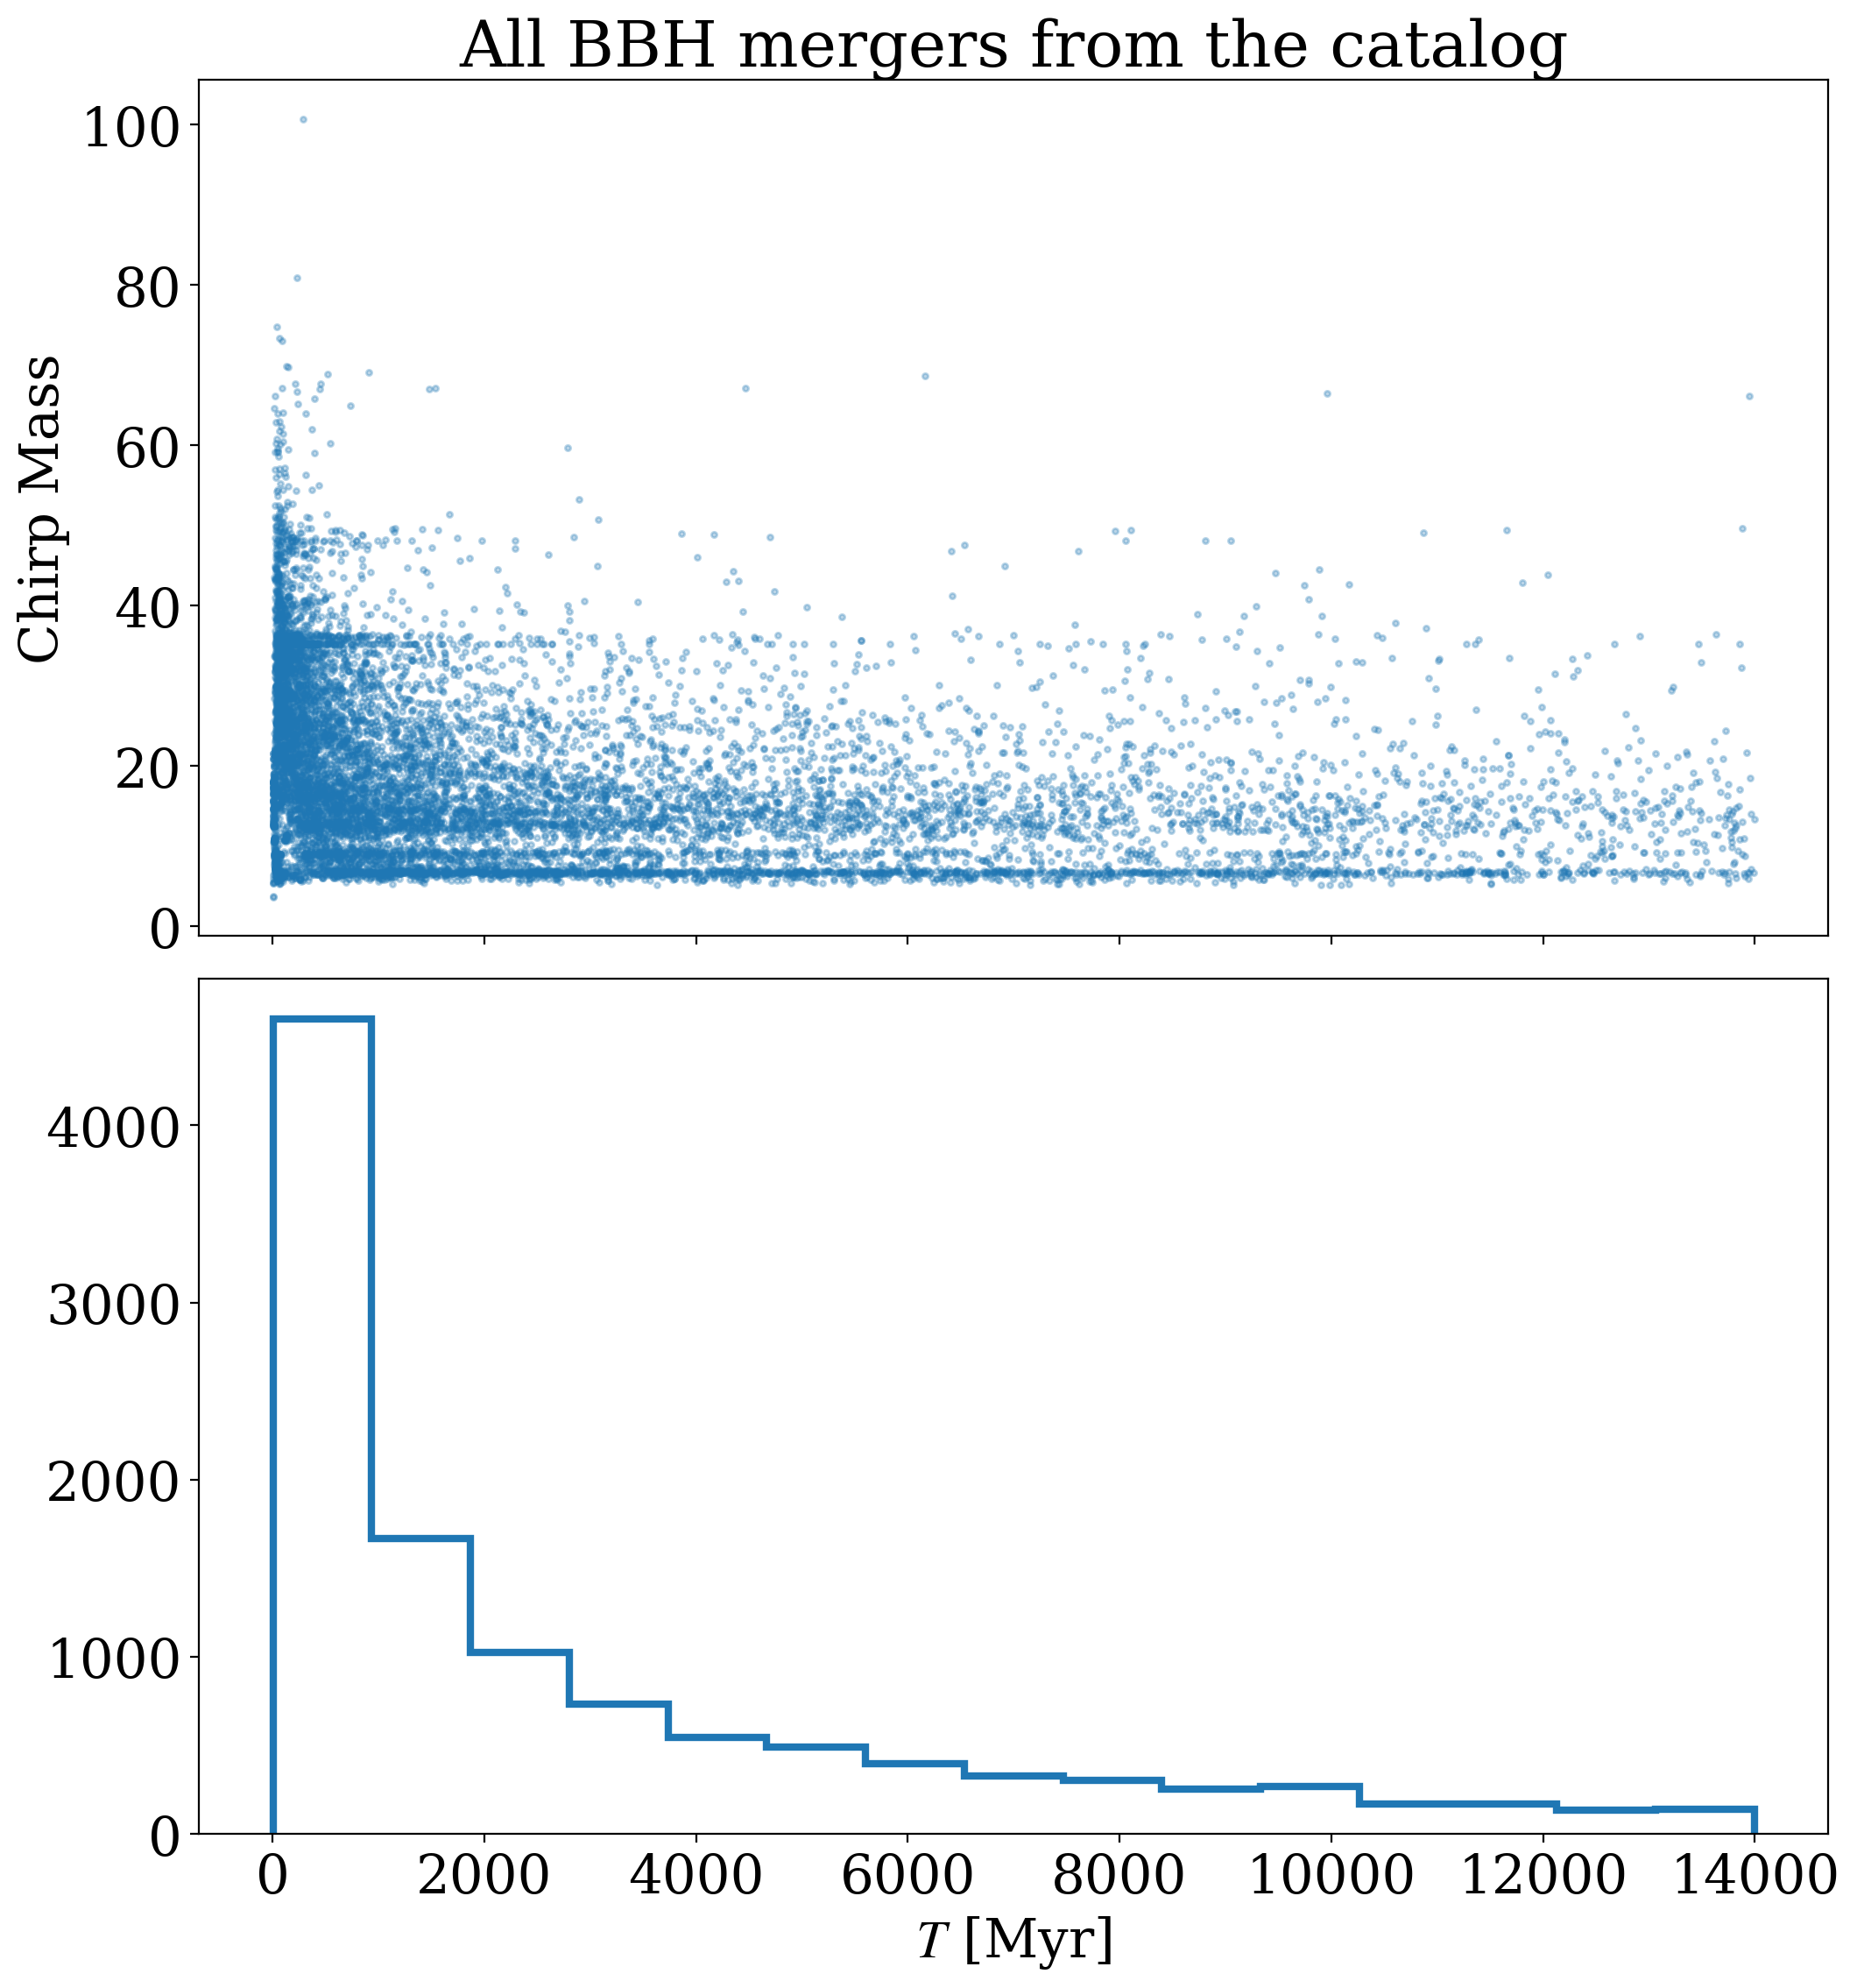

In [31]:
###import merger data; BBH
t_hub=14000.

m0 = []; m1 = []; bbh_type = []; t_mer = []

bbh_col = np.genfromtxt(savepath+'GWcap_BBH_maingrid.dat')
three_col = bbh_col[:,12]
bbh_mer = np.genfromtxt(savepath+'Incluster_BBH_maingrid.dat')
bbh_esc = np.genfromtxt(savepath+'Esc_BBH_maingrid.dat')
t_merger = bbh_esc[:,2]+bbh_esc[:,3]

m0 = m0+list(bbh_col[:,10][three_col==-100])
m1 = m1+list(bbh_col[:,11][three_col==-100])
bbh_type = bbh_type+list(np.full_like(bbh_col[:,10][three_col==-100], 1))
t_mer = t_mer + list(bbh_col[:,2][three_col==-100])
print(len(bbh_col[:,10][three_col==-100]))

m0 = m0+list(bbh_mer[:,7])
m1 = m1+list(bbh_mer[:,8])
bbh_type = bbh_type+list(np.full_like(bbh_mer[:,7], 2))
t_mer = t_mer + list(bbh_mer[:,2])
print(len(bbh_mer[:,7]))

m0=m0+list(bbh_esc[:,4][t_merger<=t_hub])
m1=m1+list(bbh_esc[:,5][t_merger<=t_hub])
bbh_type = bbh_type+list(np.full_like(bbh_esc[:,4][t_merger<=t_hub], 3))
t_mer = t_mer + list(t_merger[t_merger<=t_hub])

m_chirp = chirp_mass(np.array(m0), np.array(m1))
print(len(m_chirp), len(t_mer))

fig, axs = plt.subplots(nrows = 2, figsize=(12,13), sharex=True)
axs[0].scatter(t_mer, m_chirp, s=5, alpha=0.3)
axs[1].hist(t_mer, bins=15, histtype='step', lw=3)
#axs[0].set_yscale('log')
#axs[0].set_xscale('log')
axs[1].set_xlabel(r'$T$ [Myr]')
axs[0].set_ylabel('Chirp Mass')
axs[0].set_title('All BBH mergers from the catalog')
plt.subplots_adjust(hspace=0.05)

[22.932756839073644, 16.311510286859345, 15.16459077787041, 14.353395477319078, 14.868503088954128, 14.047145348668092, 13.39688460484085, 13.541899669664353, 14.123566268672924, 13.775544683942384, 13.859787535339718, 13.274779772553371, 13.652066845529488, 13.463905693876969] [21.488303780301614, 14.273714293705982, 13.484712146067883, 13.022880012027233, 13.485780113370257, 13.06784397608799, 12.273275865714762, 12.608094225018226, 12.830445983201622, 11.969766137482663, 12.572978614856853, 12.198045359706656, 12.656226212926825, 12.0388897167362]


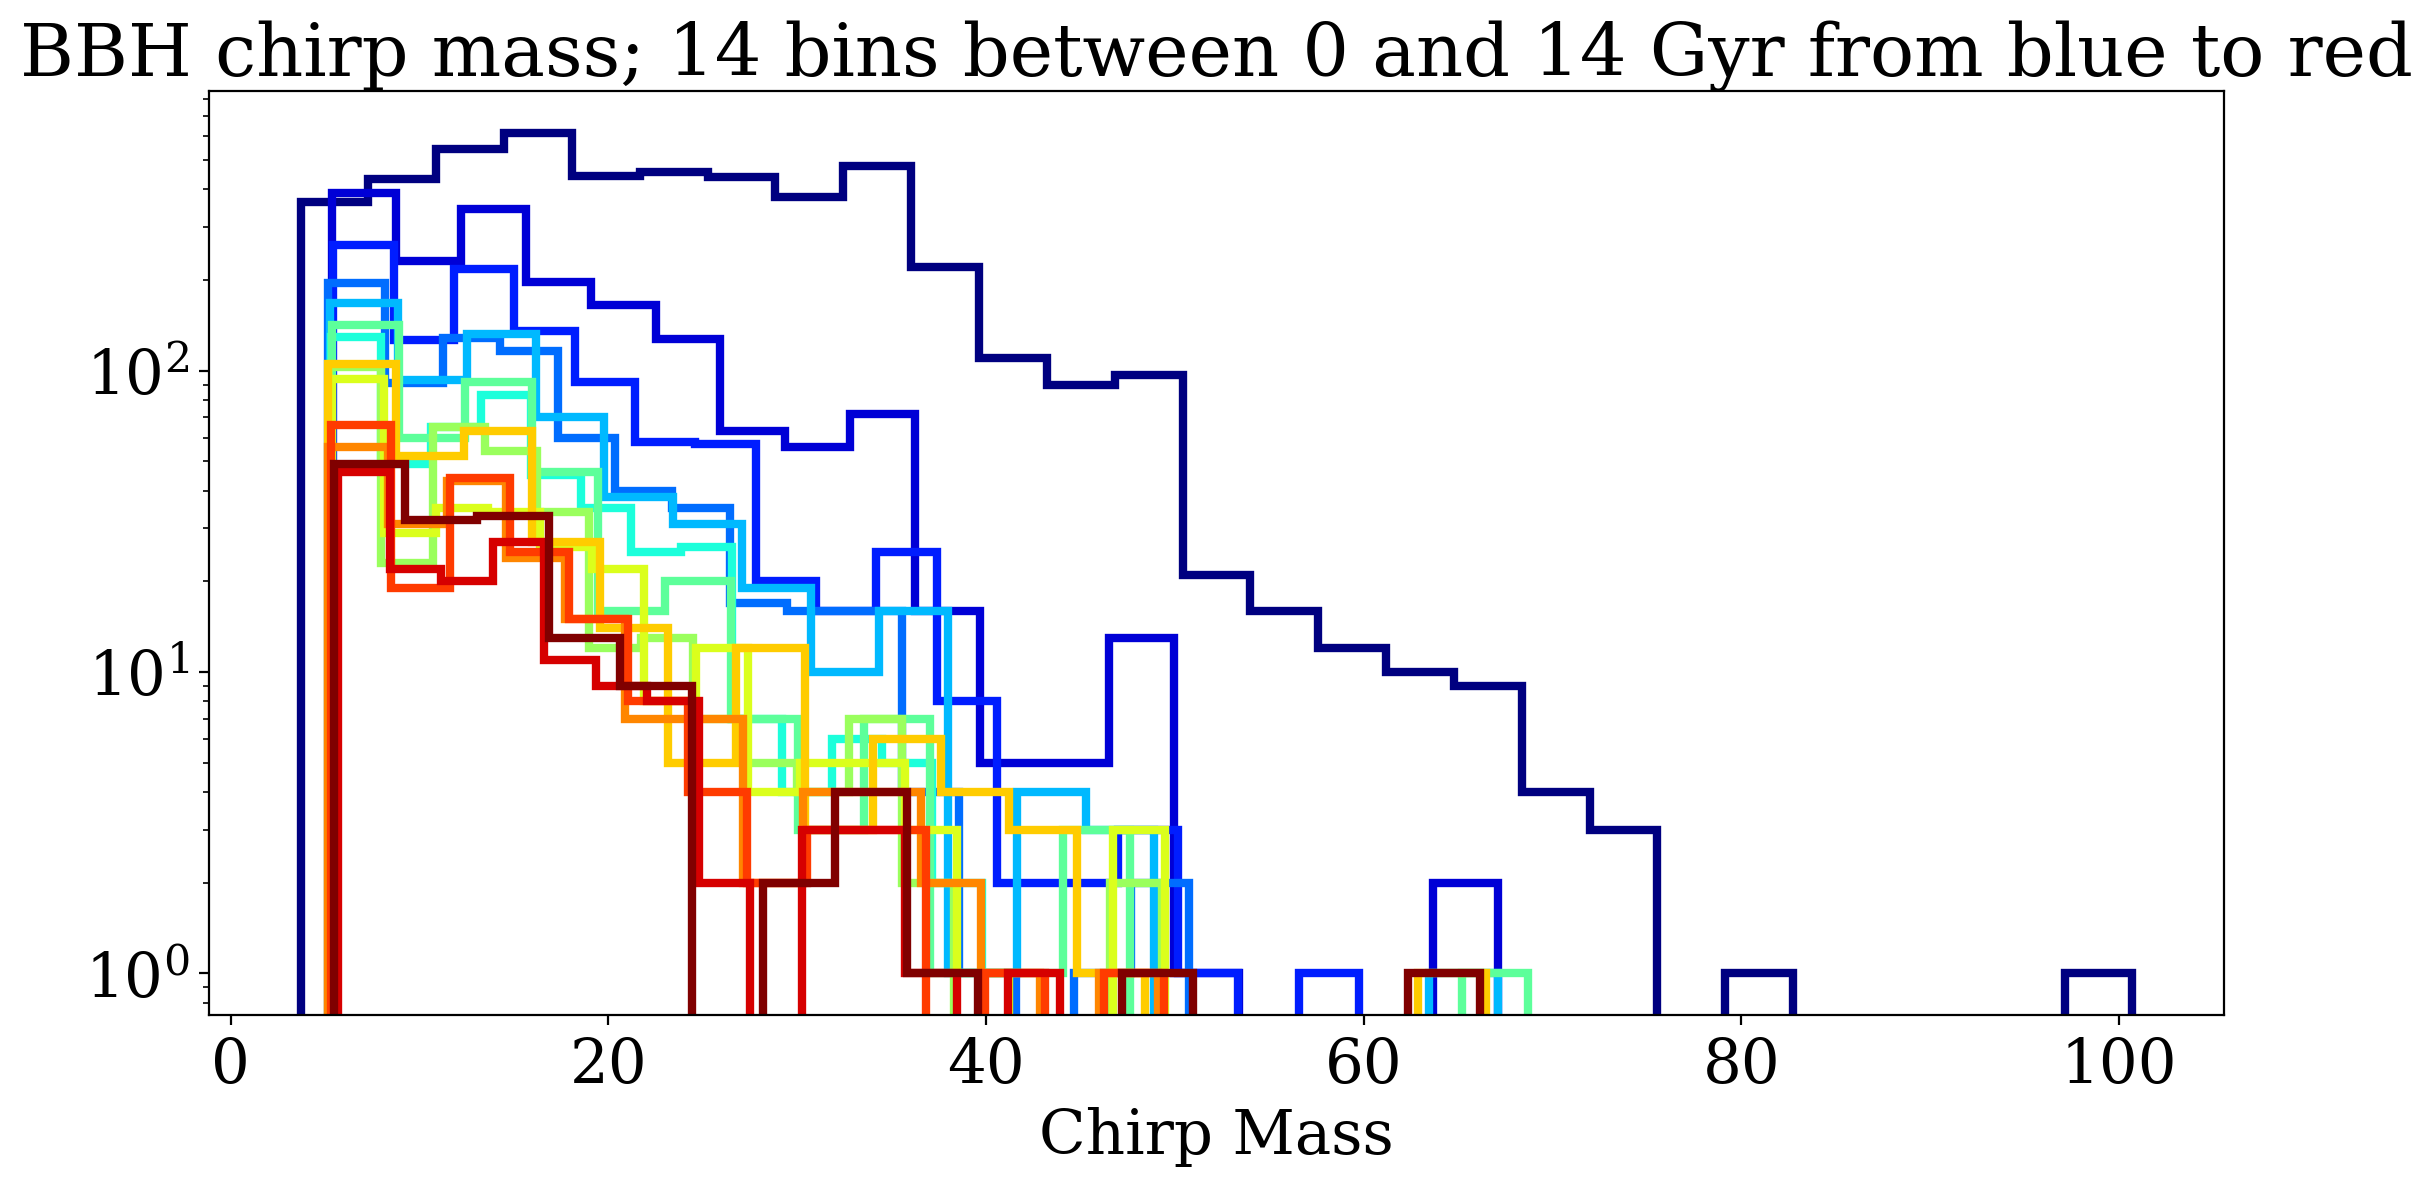

In [7]:
##BBH mass distribution as a function of time
M0 = np.maximum(m0,m1)
M1 = np.minimum(m0,m1)
m0 = np.array(m0); m1 = np.array(m1)
mtot = m0+m1
t_mer = np.array(t_mer)

mean_chirp = []; median_chirp = []

cs = cm.jet(np.linspace(0, 1, 14))
bin_size=[27, 18, 17, 15, 17, 13, 18, 16, 16, 17, 14, 14, 14, 16]
fig, axs = plt.subplots(figsize=(13,6))
t_step = 0.
while t_step < 14000.:
    step = int(t_step/1000)
    #hist, bin_edges = np.histogram(m_chirp[(t_mer < t_step+1000.) & (t_mer>=t_step)])
    mean_chirp.append(np.mean(m_chirp[(t_mer < t_step+1000.) & (t_mer>=t_step)]))
    median_chirp.append(np.median(m_chirp[(t_mer < t_step+1000.) & (t_mer>=t_step)]))
    m_step = m_chirp[(t_mer < t_step+1000.) & (t_mer>=t_step)]
    axs.hist(m_step, 
             bins = bin_size[step],#'auto',#np.logspace(np.log10(np.min(m_step)), np.log10(np.max(m_step)), 10), 
             color = cs[step],
             histtype='step', lw=3, label = str(t_step/1000.)+' Gyr')
    
    t_step+=1000.
    
axs.set_xlabel('Chirp Mass')
#axs.set_xscale('log')
axs.set_yscale('log')
#axs.legend(loc='best')
axs.set_title('BBH chirp mass; 14 bins between 0 and 14 Gyr from blue to red')

print(mean_chirp, median_chirp)

In [33]:
###read data and define plots
from importlib import reload
reload(gcr)

bbh_data = gcr.read_data('/fs/lustre/cita/claireshiye/projects/BBH_catalog/')

def plot_cluster_rate(zmin, zmax, ml, mh, dz = 0.2, z_gc = 2.2, a = 2.6, b = 3.6, sigma_dex = 0.5, Zsun = 0.02,
                     mu_rv = 2, sigma_rv = 2, beta = -2, logMstar0 = 6.26, rho_GC = 7.3e14,
                     logDelta = 5.33, logMlo = 4, logMhi = 8, plot_kwargs = {}):
    z_c = np.arange(zmin, zmax + dz, step = dz)
    R_z_c = [gcr.merger_rate_at_z_pop_selfconsistentfactors(
        bbh_data, z, ml, mh, z_gc, a, b, sigma_dex, Zsun, mu_rv, sigma_rv, beta, logMstar0, rho_GC, logDelta, logMlo, logMhi) for z in z_c]
    
    plt.plot(z_c, R_z_c, **plot_kwargs)
    plt.xlabel(r'redshift $z$')
    plt.xlim(zmin, zmax)
    plt.ylabel(r'$\mathcal{R}(z)\,[\rm{Gpc^{-3}\,yr^{-1}}]$')
    plt.yscale('log')

[32.4567   29.4702   30.1248   ... 13.066553 11.506553 21.892913] [18.2013   75.0093   32.9007   ...  8.16715  12.010541  9.07032 ] 1103


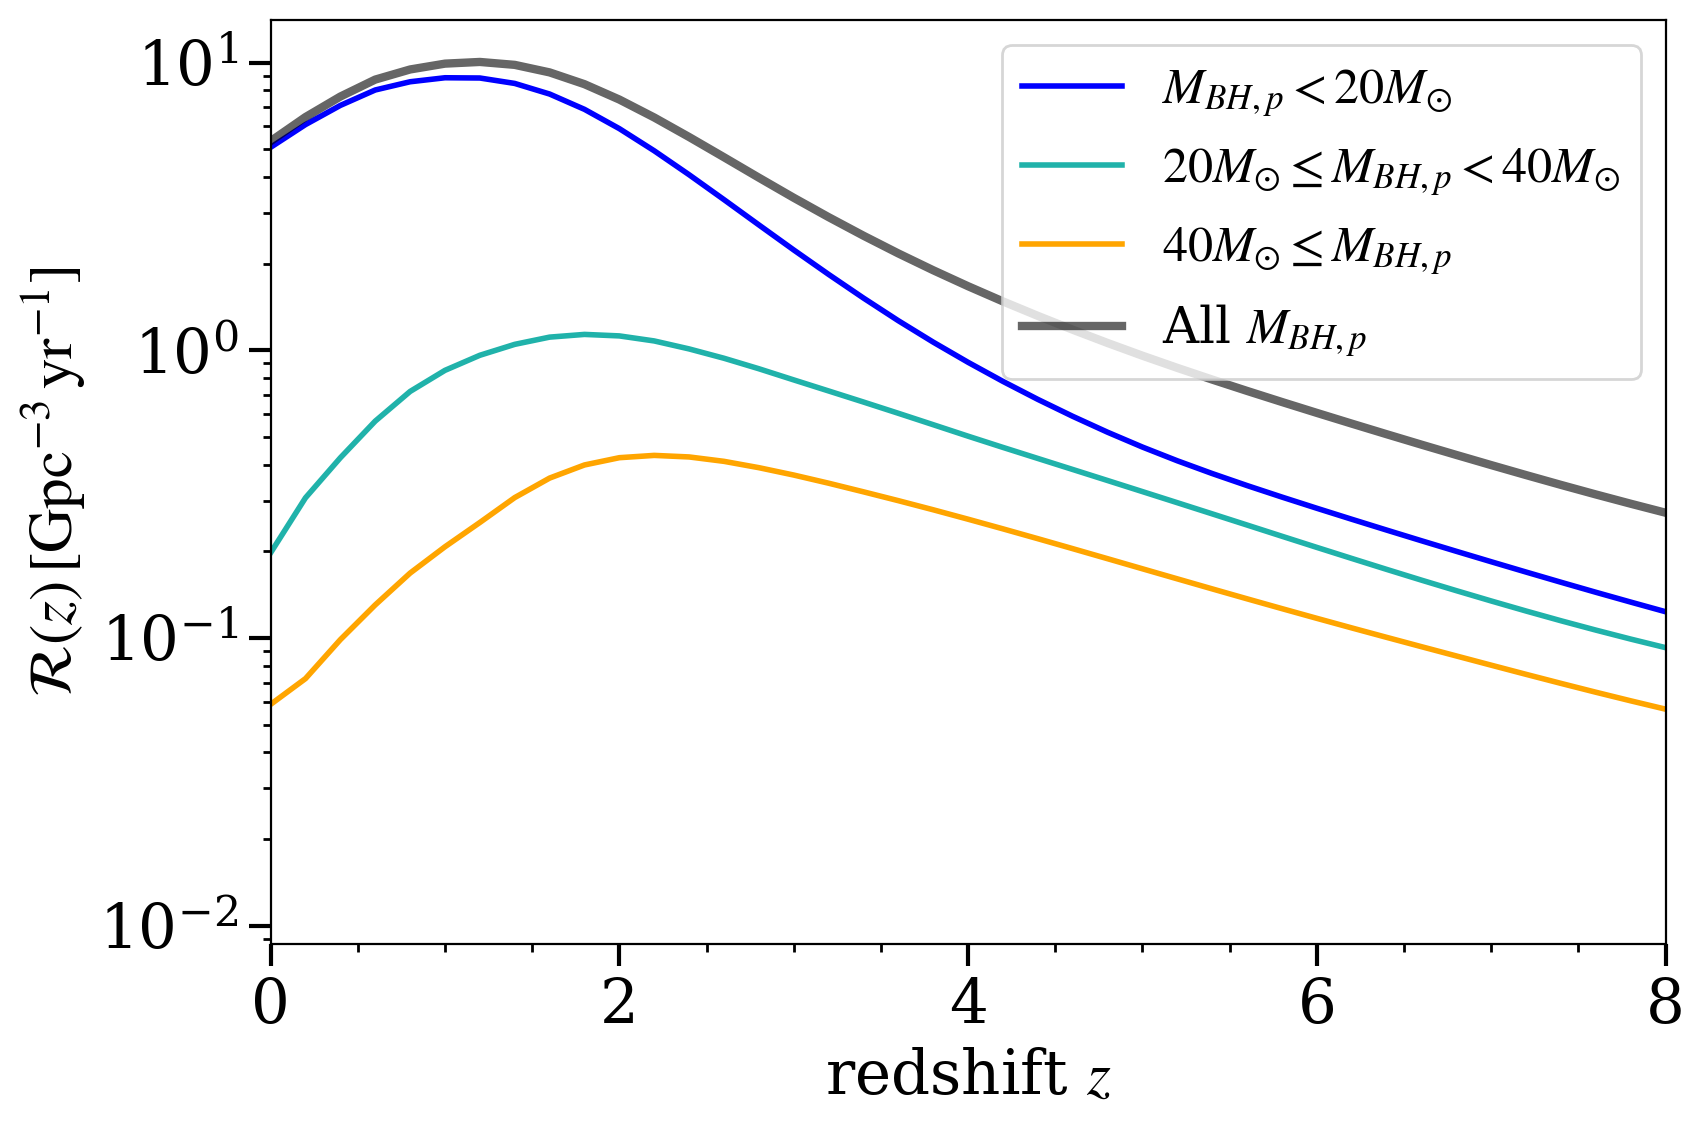

In [34]:
fig, ax = plt.subplots(figsize=(9,6))
plot_cluster_rate(0, 20, 0, 20, 
                  plot_kwargs = dict(label = r'$ M_{BH, p} < 20 M_{\odot} $',linewidth = 2, color='b'))
plot_cluster_rate(0, 20, 20, 40, 
                  plot_kwargs = dict(label = r'$20M_{\odot}  \leq M_{BH, p} < 40 M_{\odot} $',linewidth = 2, 
                                     color = 'lightseagreen'))
plot_cluster_rate(0, 20, 40, 1000, 
                  plot_kwargs = dict(label = r'$40 M_{\odot} \leq M_{BH, p}$',linewidth = 2,
                                    color='orange'))
plot_cluster_rate(0, 20, 0, 1000, 
                  plot_kwargs = dict(label = r'All $ M_{BH, p} $',linewidth = 3, color='k', alpha=0.6))

ax.set_xlim(xmax=8)
#ax.set_ylim(ymin=0.04)
plt.legend(loc='upper right', fontsize=18, frameon=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params('both', length=8, width=1.5, which='major')
ax.tick_params('both', length=3, width=1, which='minor')

#plot_cluster_rate(0, 20, 30, 40, plot_kwargs = dict(label = r'$30 M_{\odot} \leq M_{BH, p} < 40 M_{\odot} $',linewidth = 2))
#plot_cluster_rate(0, 20, 40, 50, plot_kwargs = dict(label = r'$40 M_{\odot} \leq M_{BH, p} < 50 M_{\odot} $',linewidth = 2))
#plot_cluster_rate(0, 20, 50, 1000, plot_kwargs = dict(label = r'$50 M_{\odot} \leq M_{BH, p}$',linewidth = 2))

Text(0, 0.5, '$N$')

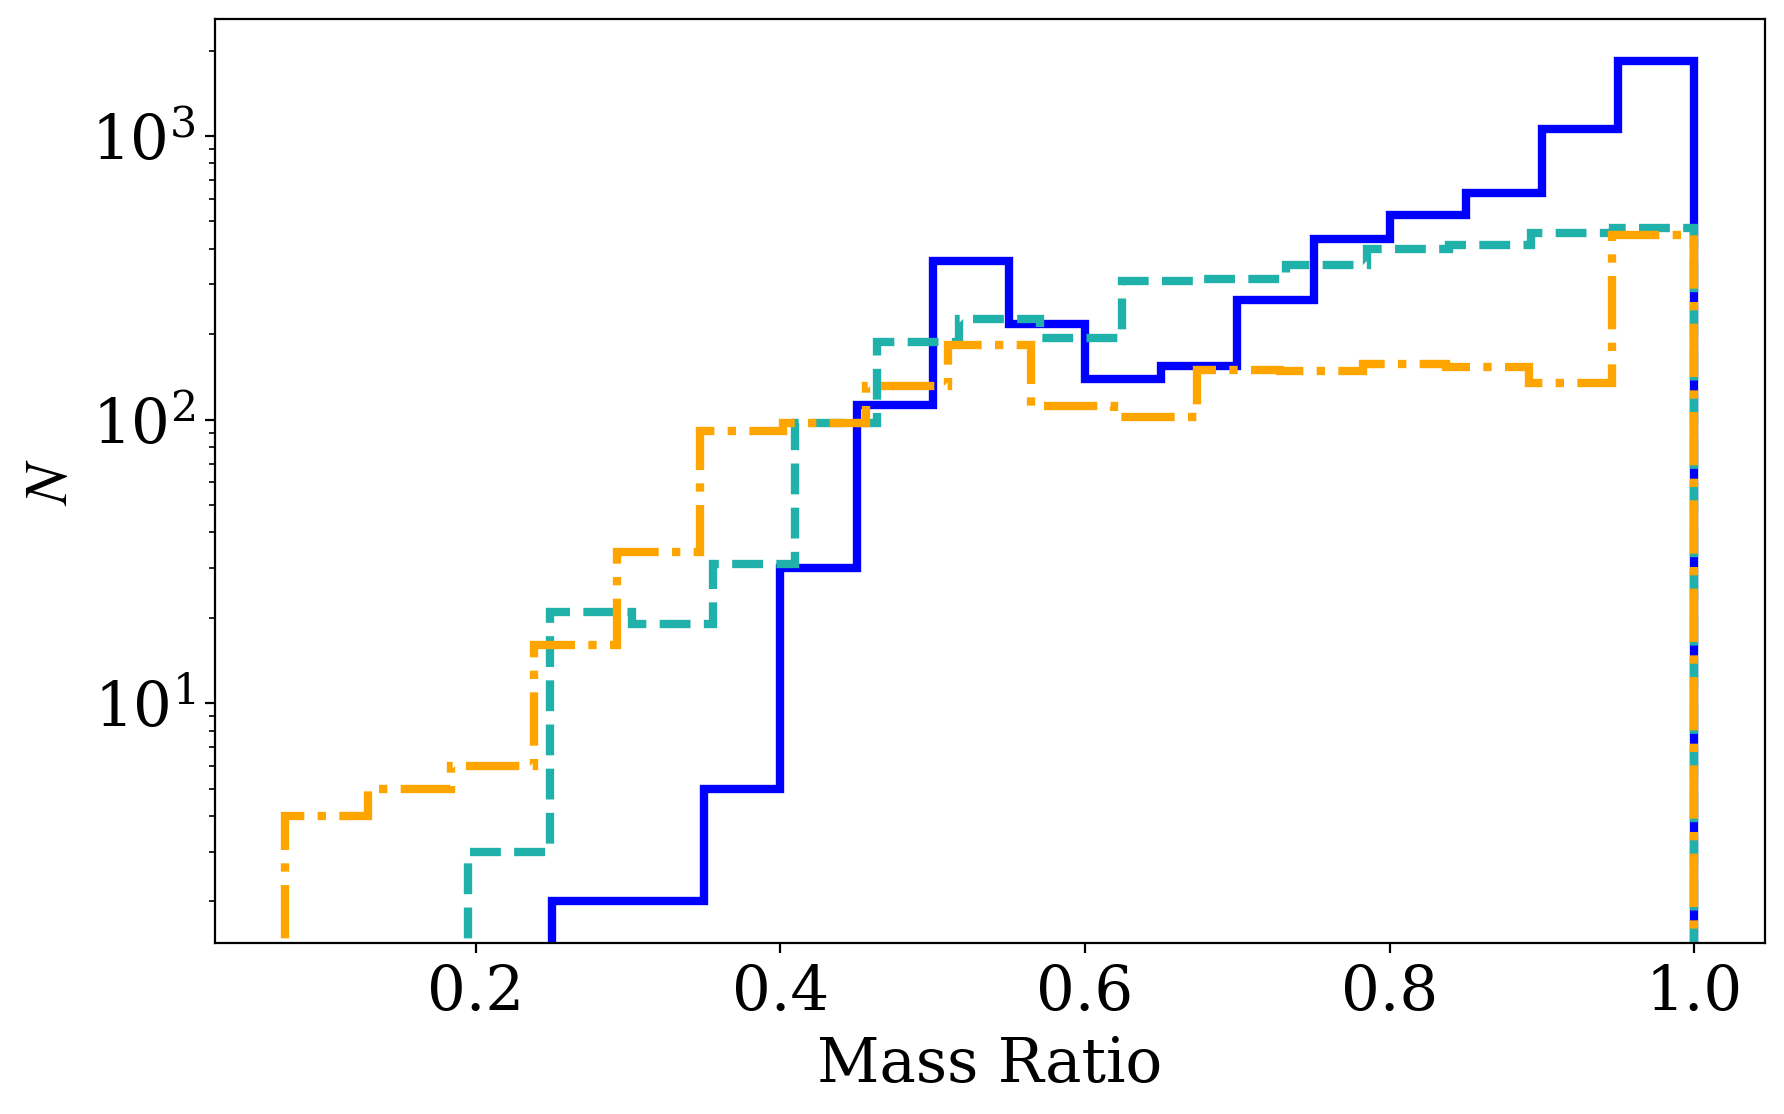

In [25]:
##Mass ratios
m_q = M1/M0

fig, axs = plt.subplots(figsize=(10,6))
axs.hist(m_q[M0<20], bins=15, 
         histtype='step', color='b', lw=3.)
axs.hist(m_q[(M0<40) & (M0>=20)], bins=15,
         histtype='step', color='lightseagreen', lw=3, ls='--')
axs.hist(m_q[M0>=40], bins=17,
         histtype='step', color='orange', lw=3, ls='dashdot')
axs.set_yscale('log')
axs.set_xlabel('Mass Ratio')
axs.set_ylabel(r'$N$')

5 9 0
11234 1528 9 0
373 58


Text(0, 0.5, '$M_1\\,[M_{\\odot}]$')

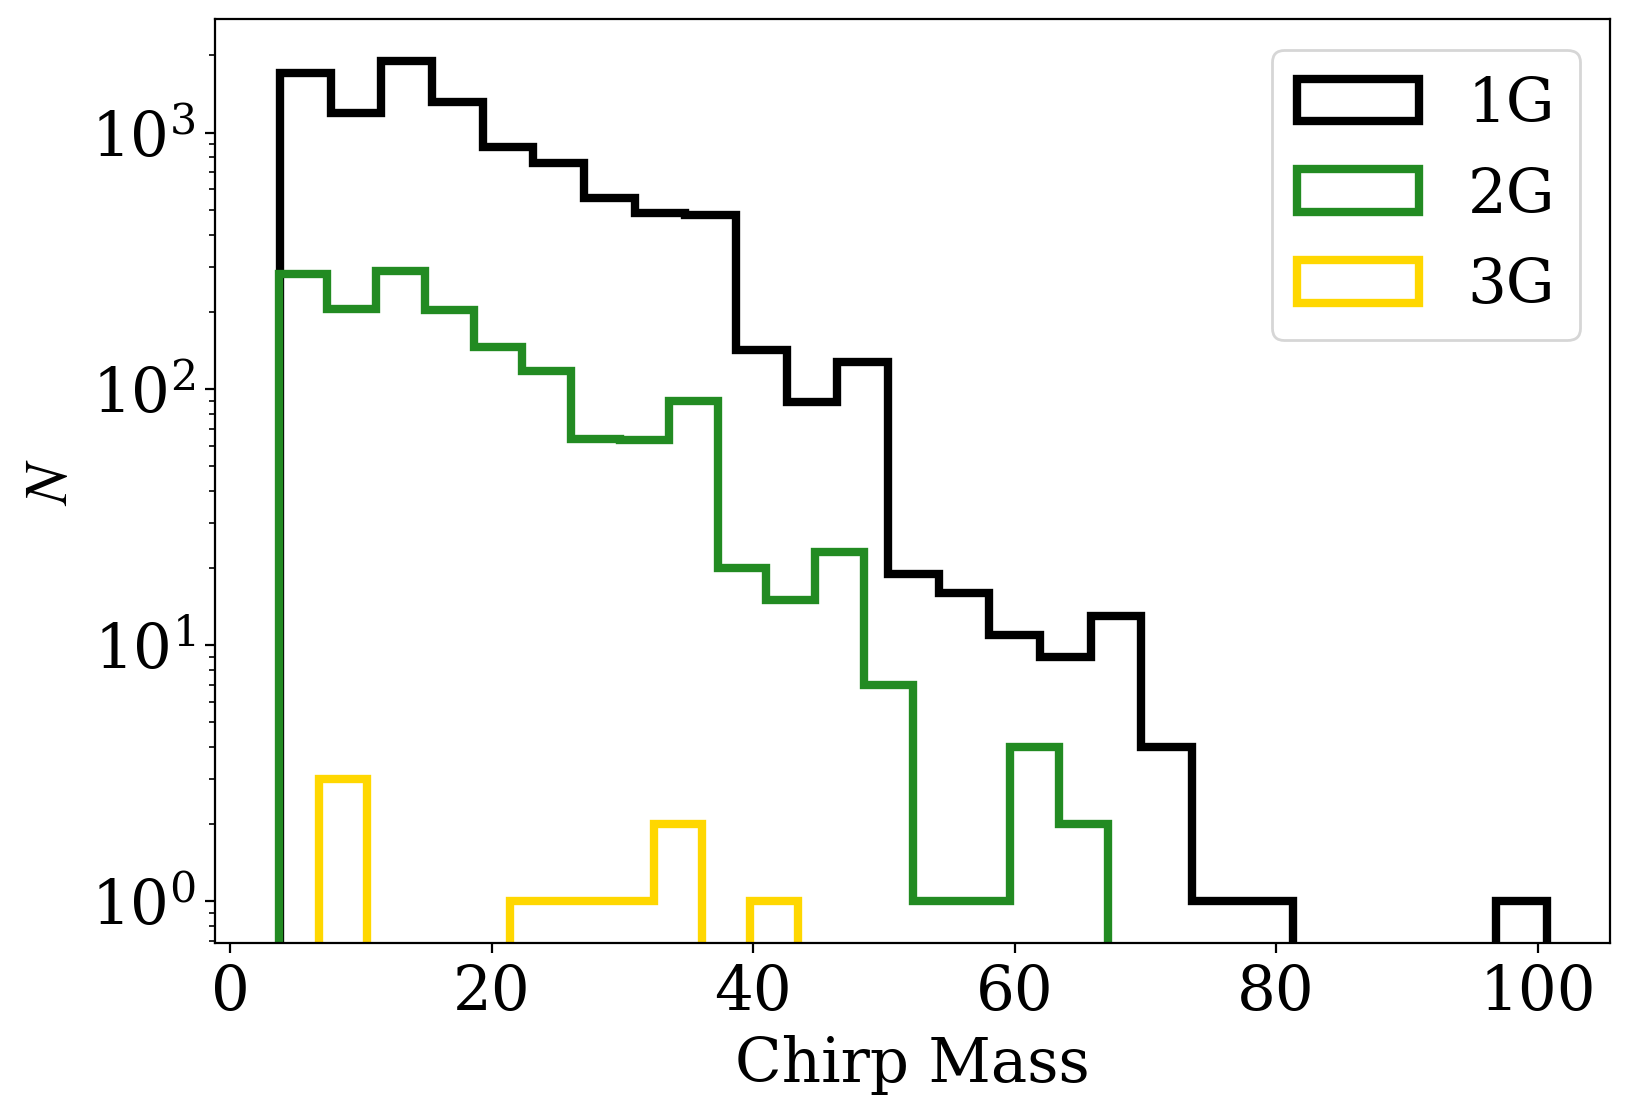

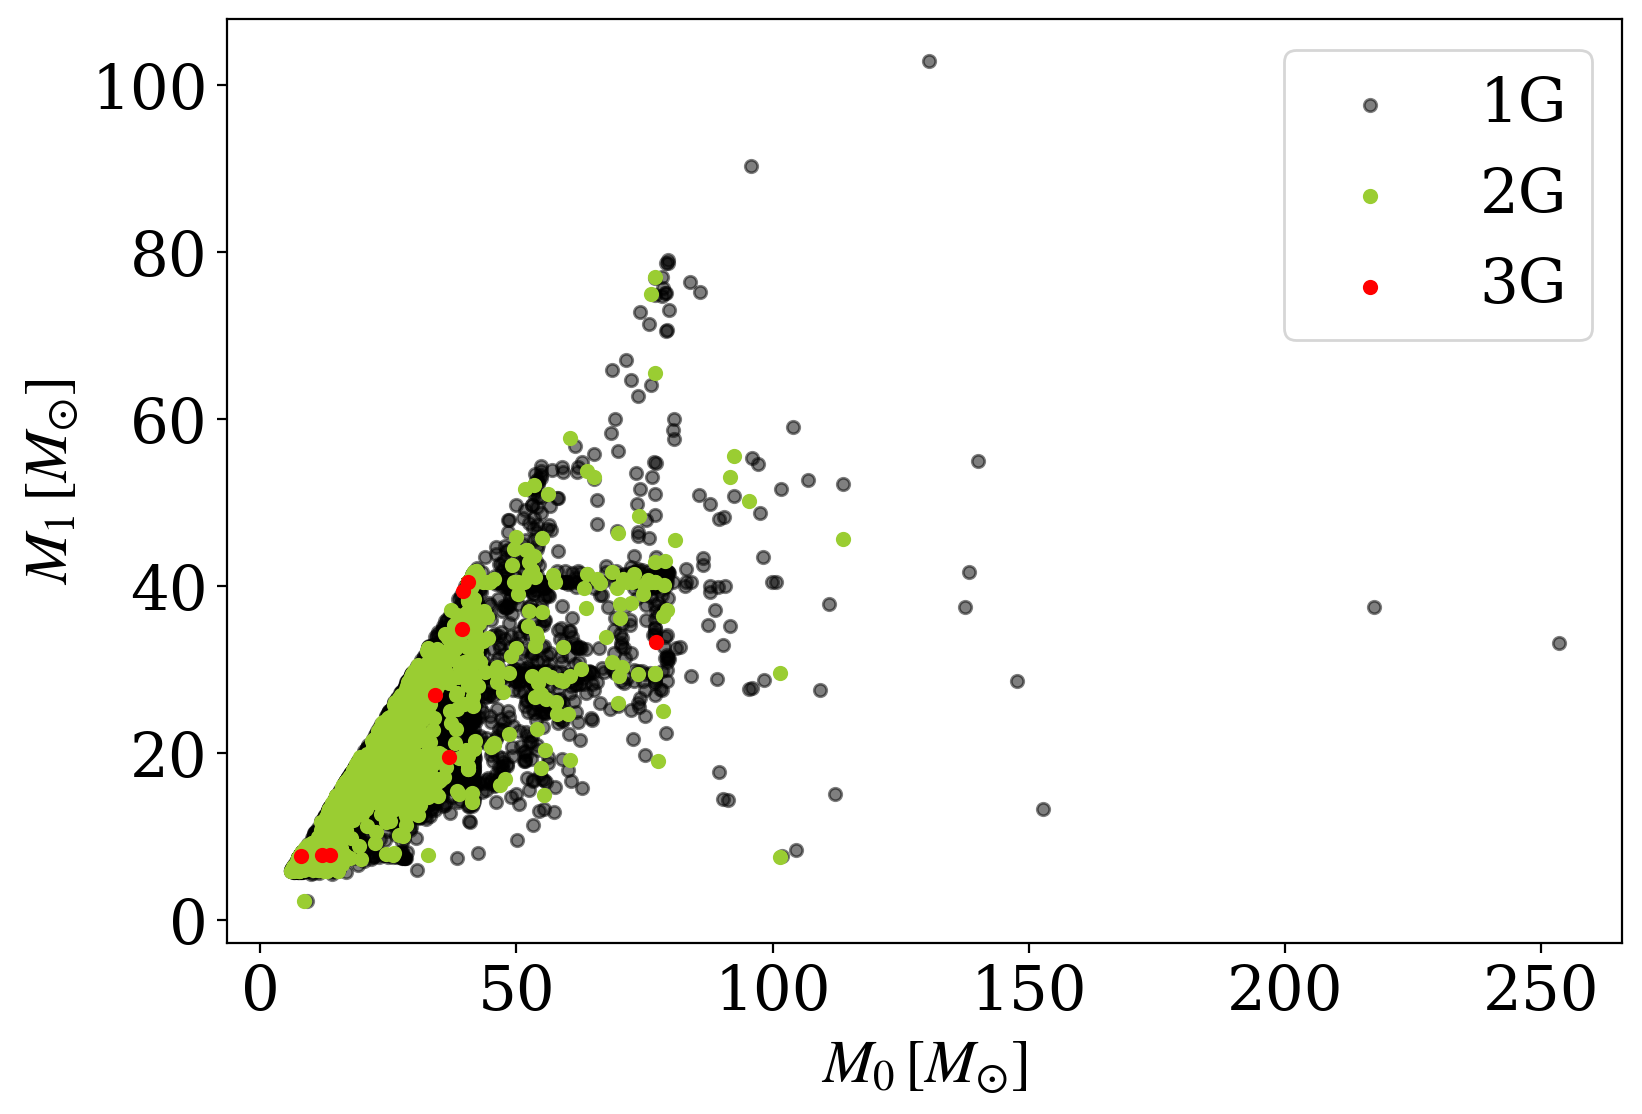

In [73]:
##Check repeated mergers
M0 = np.maximum(m0,m1)
M1 = np.minimum(m0,m1)
m0 = np.array(m0); m1 = np.array(m1)
mtot = m0+m1
t_mer = np.array(t_mer)


t_hub = 14000.

model_no = []
IDM = []; IDs = [[],[]]; bbh_type = []; t_mer = []
repeater = []  ##11-1G, 12 or 21-one 2G, etc

bbh_col = np.genfromtxt(savepath+'GWcap_BBH_maingrid.dat')
num_col = bbh_col[:,3]
bbh_mer = np.genfromtxt(savepath+'Incluster_BBH_maingrid.dat')
bbh_esc = np.genfromtxt(savepath+'Esc_BBH_maingrid.dat')
t_merger = bbh_esc[:,2]+bbh_esc[:,3]


IDM = IDM+list(bbh_col[:,4][num_col==2])
IDs[0] = IDs[0]+list(bbh_col[:,5][num_col==2])
IDs[1] = IDs[1]+list(bbh_col[:,6][num_col==2])
bbh_type = bbh_type+list(np.full_like(bbh_col[:,10][num_col==2], 1))
t_mer = t_mer + list(bbh_col[:,2][num_col==2])
model_no = model_no+list(bbh_col[:,0][num_col==2])

IDM = IDM+list(bbh_mer[:,3])
IDs[0] = IDs[0]+list(bbh_mer[:,4])
IDs[1] = IDs[1]+list(bbh_mer[:,5])
bbh_type = bbh_type+list(np.full_like(bbh_mer[:,7], 2))
t_mer = t_mer + list(bbh_mer[:,2])
model_no = model_no+list(bbh_mer[:,0])

IDM = IDM+list(np.full_like(bbh_esc[:,4][t_merger<=t_hub], -100))
IDs[0] = IDs[0]+list(bbh_esc[:,6][t_merger<=t_hub])
IDs[1] = IDs[1]+list(bbh_esc[:,7][t_merger<=t_hub])
bbh_type = bbh_type+list(np.full_like(bbh_esc[:,4][t_merger<=t_hub], 3))
t_mer = t_mer + list(t_merger[t_merger<=t_hub])
model_no = model_no+list(bbh_esc[:,0][t_merger<=t_hub])


unique_modelno = np.unique(model_no)
model_no = np.array(model_no)
IDM = np.array(IDM)
IDs[0] = np.array(IDs[0]); IDs[1] = np.array(IDs[1])
bbh_type = np.array(bbh_type)
t_mer = np.array(t_mer)
print(len(IDM[IDM==0]), len(IDs[0][IDs[0]==0]), len(IDs[1][IDs[1]==0]))
#print(model_no[(IDM==0) | (IDs[0]==0) | (IDs[1]==0)])


##marking repeated mergers
gen_mer = [[],[],[]]
for xx in range(len(unique_modelno)): #
    #print(xx, unique_modelno[xx])
    
    tmer_model = t_mer[(model_no==unique_modelno[xx])]# & (IDM!=0)]
    IDM_model = IDM[(model_no==unique_modelno[xx])]# & (IDM!=0)]
    ID0_model = IDs[0][(model_no==unique_modelno[xx])]# & (IDM!=0)]
    ID1_model = IDs[1][(model_no==unique_modelno[xx])]# & (IDM!=0)]
    
    index_sort = np.argsort(tmer_model)
    #print(tmer_model[index_sort])
    
    IDM_sort = IDM_model[index_sort]
    ID0_sort = ID0_model[index_sort]
    ID1_sort = ID1_model[index_sort]
    
    check = [np.full_like(IDM_sort, 1), np.full_like(IDM_sort, 1), np.full_like(IDM_sort, 1)]
    yy = 1
    while yy < len(IDM_sort):
        #print(IDM_sort[:yy], ID0_sort[yy], ID1_sort[yy])
        if ID0_sort[yy] in IDM_sort[:yy]:
            index_check = np.where(IDM_sort[:yy]==ID0_sort[yy])[0]
            check[0][yy] = check[0][yy]+check[2][index_check[-1]]
                
        if ID1_sort[yy] in IDM_sort[:yy]:
            index_check = np.where(IDM_sort[:yy]==ID1_sort[yy])[0]
            check[1][yy] = check[1][yy]+check[2][index_check[-1]]
            
        check[2][yy]=np.maximum(check[0][yy], check[1][yy])
           
        yy+=1
            
    gen_mer[0] = gen_mer[0]+list(check[2])
    gen_mer[1] = gen_mer[1]+list(check[0])
    gen_mer[2] = gen_mer[2]+list(check[1])
    
    
gen_mer[0]=np.array(gen_mer[0])
gen_mer[1]=np.array(gen_mer[1])
gen_mer[2]=np.array(gen_mer[2])

print(len(gen_mer[0]), len(gen_mer[0][gen_mer[0]==2]), len(gen_mer[0][gen_mer[0]==3]), len(gen_mer[0][gen_mer[0]==4]))

from IPython.display import display
  
# creating a DataFrame
dict = {'tmer [Myr]' : tmer_model[index_sort],
        'IDM' : IDM_sort,
        'ID0' : ID0_sort,
        'ID1' : ID1_sort,
        'type': bbh_type[(model_no==unique_modelno[xx]) & (IDM!=0)][index_sort],
        'check2': check[2],
        'check0': check[0],
        'check1': check[1]}
df = pd.DataFrame(dict)
  
# displaying the DataFrame
#pd.set_option('display.max_rows', None)
#display(df)


##Mass of different gen mergers
fig, axs = plt.subplots(figsize=(9,6))
axs.hist(m_chirp[gen_mer[0]==1], bins=25,
         lw=3, histtype='step', color='k', label = '1G')
axs.hist(m_chirp[gen_mer[0]==2], bins=17,
         lw=3, histtype='step', color='forestgreen', label = '2G')
axs.hist(m_chirp[gen_mer[0]==3], 
         lw=3, histtype='step', color='gold', label = '3G')
axs.set_yscale('log')
axs.legend(loc='best')
axs.set_xlabel('Chirp Mass')
axs.set_ylabel(r'$N$')

print(len(m_chirp[(m_chirp>=40) & (gen_mer[0]==1)]), len(m_chirp[(m_chirp>=40) & (gen_mer[0]==2)]))

fig, axs = plt.subplots(figsize=(9,6))
axs.scatter(M0[gen_mer[0]==1], M1[gen_mer[0]==1],
          color='k', alpha=0.5, s=20, label = '1G')
axs.scatter(M0[gen_mer[0]==2], M1[gen_mer[0]==2],
         color='yellowgreen', s=20, label = '2G')
axs.scatter(M0[gen_mer[0]==3], M1[gen_mer[0]==3],
         color='red', s=20, label = '3G')
#axs.set_yscale('log')
#axs.set_xscale('log')
axs.legend(loc='best')
axs.set_xlabel(r'$M_0\,[M_{\odot}]$')
axs.set_ylabel(r'$M_1\,[M_{\odot}]$')

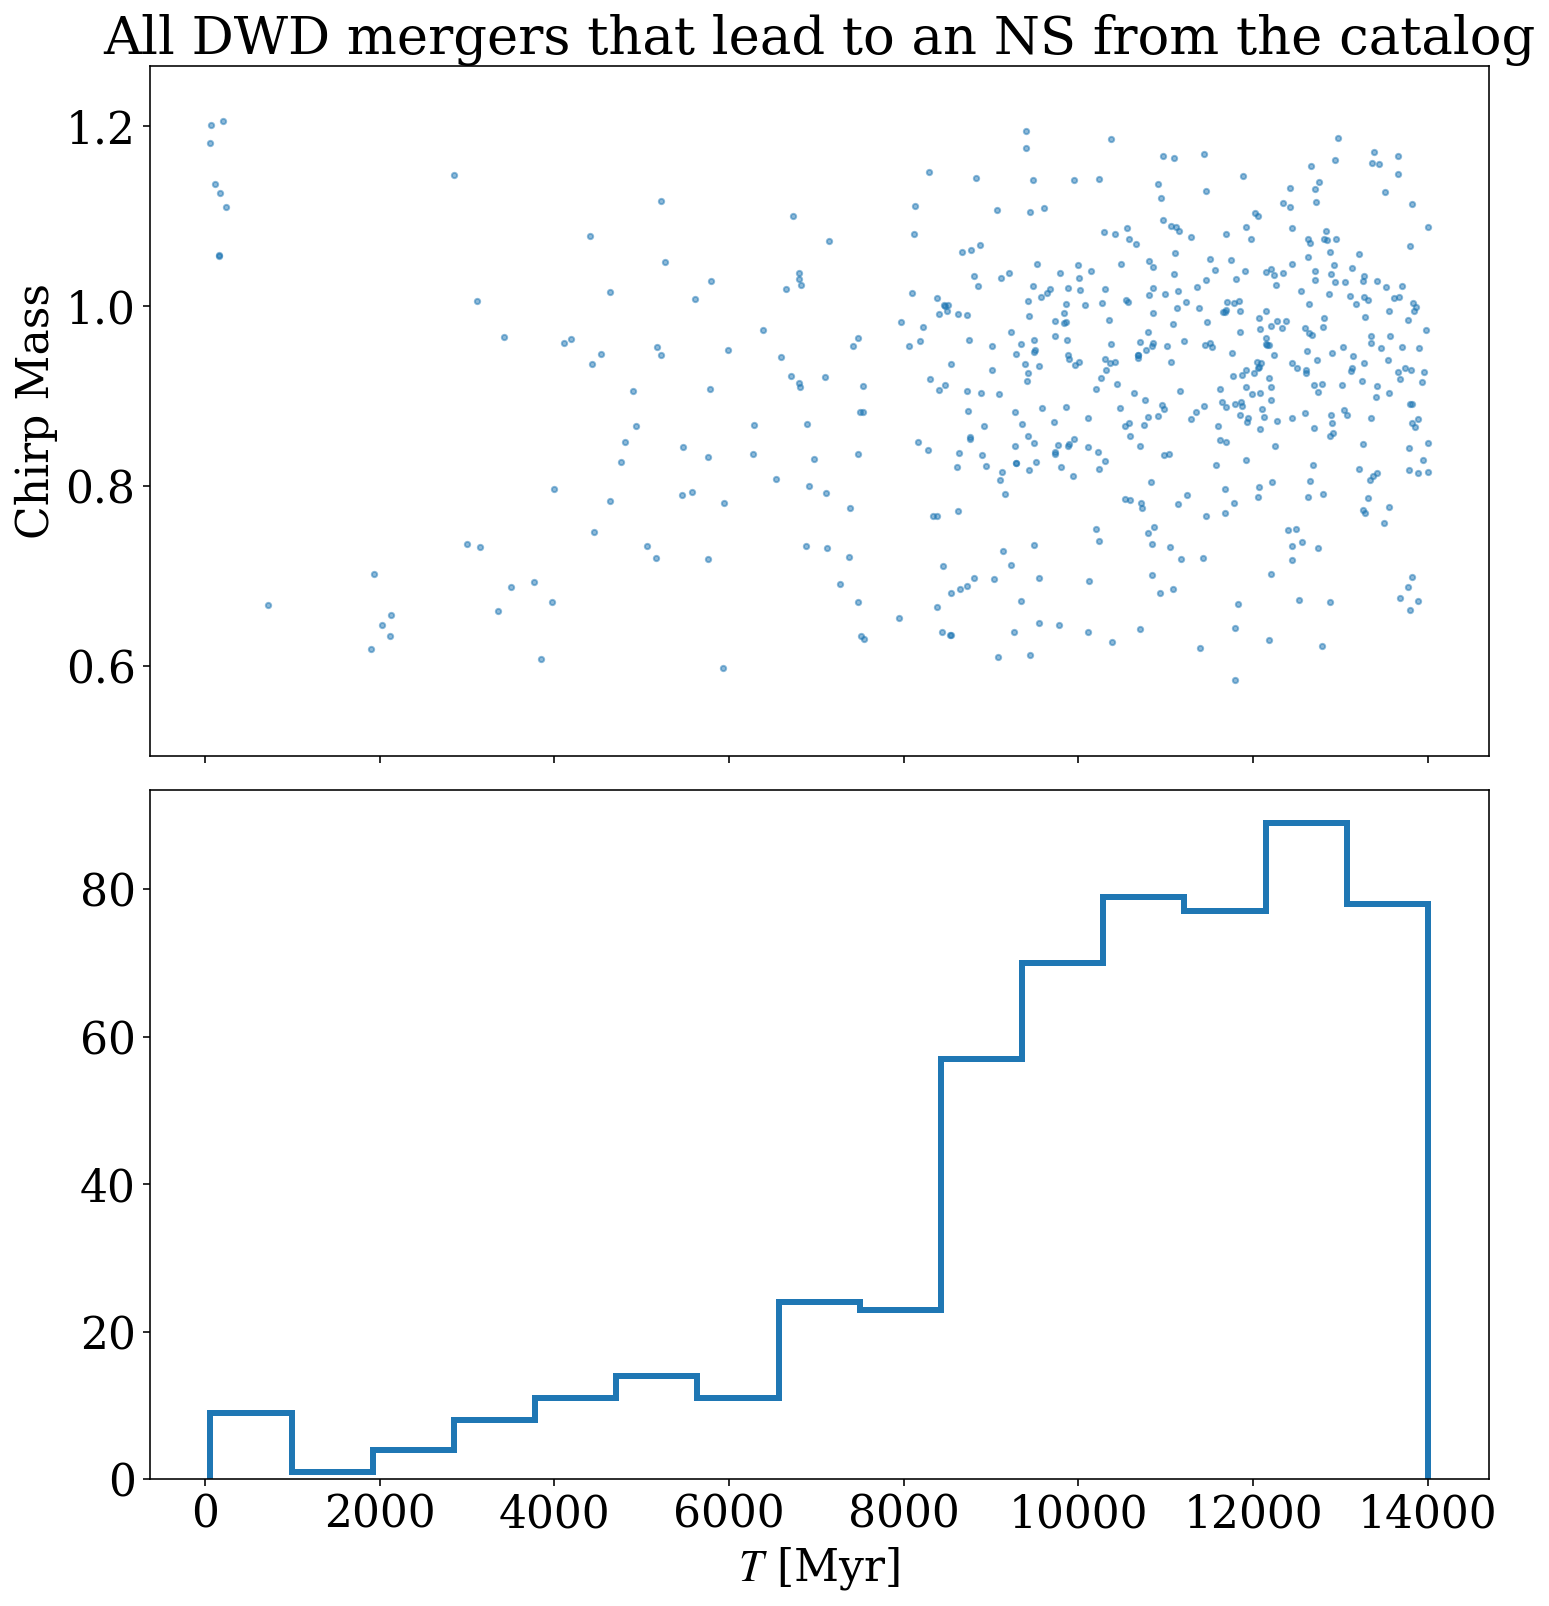

In [11]:
###import merger data; WD-WD where the remnant is a NS
m0_wd = []; m1_wd = []; dwd_type = []; t_mer_wd = []

ns_allcol = np.genfromtxt('/projects/b1095/syr904/projects/SGRB/newruns/finaldata/ns_collproduct_all.dat')
k0_col = ns_allcol[:,10]; k1_col = ns_allcol[:,11]; k2_col = ns_allcol[:,12]
ns_allmer = np.genfromtxt('/projects/b1095/syr904/projects/SGRB/newruns/finaldata/ns_mergerproduct_all.dat')
k0_mer = ns_allmer[:,8]; k1_mer = ns_allmer[:,9]

m0_wd = m0_wd+list(ns_allcol[:,5][(k0_col>=10) & (k0_col<=12) & (k1_col>=10) & (k1_col<=12) & (k2_col==-100)])
m1_wd = m1_wd+list(ns_allcol[:,6][(k0_col>=10) & (k0_col<=12) & (k1_col>=10) & (k1_col<=12) & (k2_col==-100)])
t_mer_wd = t_mer_wd+list(ns_allcol[:,1][(k0_col>=10) & (k0_col<=12) & (k1_col>=10) & (k1_col<=12) & (k2_col==-100)])
dwd_type = dwd_type+list(np.full_like(ns_allcol[:,5][(k0_col>=10) & (k0_col<=12) & (k1_col>=10) & (k1_col<=12) & (k2_col==-100)],
                                      1))

m0_wd = m0_wd+list(ns_allmer[:,5][(k0_mer>=10) & (k0_mer<=12) & (k1_mer>=10) & (k1_mer<=12)])
m1_wd = m1_wd+list(ns_allmer[:,6][(k0_mer>=10) & (k0_mer<=12) & (k1_mer>=10) & (k1_mer<=12)])
t_mer_wd = t_mer_wd+list(ns_allmer[:,1][(k0_mer>=10) & (k0_mer<=12) & (k1_mer>=10) & (k1_mer<=12)])
dwd_type = dwd_type+list(np.full_like(ns_allmer[:,5][(k0_mer>=10) & (k0_mer<=12) & (k1_mer>=10) & (k1_mer<=12)],2))

m_chirp_wd = chirp_mass(np.array(m0_wd), np.array(m1_wd))

fig, axs = plt.subplots(nrows=2, figsize=(12,13), sharex=True)
axs[0].scatter(t_mer_wd, m_chirp_wd, s=7, alpha=0.5)
axs[1].hist(t_mer_wd, bins=15, histtype='step', lw=3)

#axs[0].set_yscale('log')
#axs[0].set_xscale('log')
axs[0].set_ylim(ymin=0.5)
axs[1].set_xlabel(r'$T$ [Myr]')
axs[0].set_ylabel('Chirp Mass')
axs[0].set_title('All DWD mergers that lead to an NS from the catalog')
plt.subplots_adjust(hspace=0.05)